In [5]:
latex_dir = 'LaTex/img/'
EXPORT_FOR_LATEX = True

def plot_images(plot, figname=None):
    if EXPORT_FOR_LATEX:
        plt.savefig(latex_dir+figname+'.pdf', bbox_inches='tight')
    else:
        plot.show()

In [1]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats

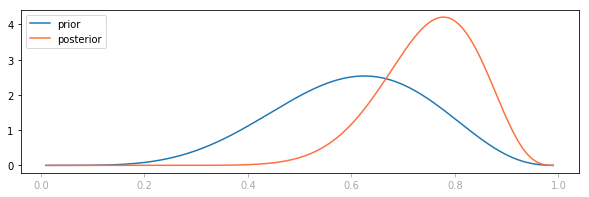

In [2]:
a,b= 6,4
N,h = 10,9
dist_in = np.arange(.01,.99,.0001)

plt.figure(figsize=(10,3))

beta_prior = stats.beta(a,b)
beta_posterior = stats.beta(a+h,b+N-h)
dist_prior = beta_prior.pdf(dist_in)
dist_posterior = beta_posterior.pdf(dist_in)

plt.plot(dist_in,dist_prior,color='#1f77b4', label='prior')
plt.plot(dist_in,dist_posterior,color='#FF703E', label='posterior')
plt.tick_params(axis='x', colors='darkgrey')
plt.legend(loc=2)

plt.show()

In [113]:
a,b= 6,4
N,h = 10,9
outcomes = np.concatenate((np.repeat(0,N-h),np.repeat(1,h))) #head = 1

with pm.Model() as model:
    th = pm.Beta('th',a,b)
    out = pm.Binomial('out',1,th,observed=outcomes)
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:00<00:00, 2956.95it/s]



th:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.755            0.095            0.003            [0.580, 0.942]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.550          0.693          0.762          0.825          0.920



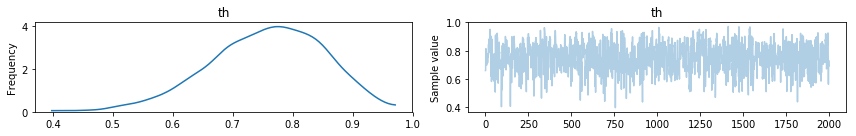

In [4]:
with model:
    pm.traceplot(trace)
    pm.summary(trace)

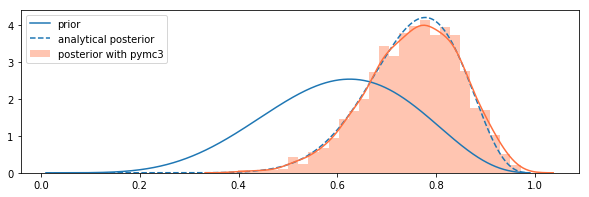

In [6]:
plt.figure(figsize=(10,3))

plt.plot(dist_in,dist_prior,color='#1f77b4', label='prior')
plt.plot(dist_in,dist_posterior,'--',color='#1f77b4', label='analytical posterior')
sns.distplot(trace['th'],label='posterior with pymc3',color='#FF703E')
plt.legend(loc=2)

plot_images(plt, '4_1')

# section 4.2

In [8]:
import time
import pandas as pd

In [9]:
experiments = pd.read_csv('data/experiments2.csv')
number_coins_used = len(experiments['coin_ID'].unique())
experiments.sample(4).head().reset_index(drop=True)

index  coin_ID  N_heads  N_tosses
0     93        2       42        64
1     72        1       61        64
2     20        0       63        64
3     42        1       55        64

In [10]:
number_coins_used

4

In [11]:
experiments[['coin_ID','N_heads']].groupby('coin_ID').mean().T

coin_ID       0      1     2     3
N_heads  59.275  54.15  45.6  25.4

In [12]:
experiments[['coin_ID','N_heads']].groupby('coin_ID').min().T

coin_ID   0   1   2  3
N_heads  45  29  29  7

In [13]:
(experiments[['coin_ID','N_heads']].groupby('coin_ID').mean()/64).rename(columns={'N_heads': 'observed probability head'}).T

coin_ID                           0         1       2         3
observed probability head  0.926172  0.846094  0.7125  0.396875

In [114]:
with pm.Model() as model:
    kappa = pm.Gamma('kappa', 1, 0.1)
    mu = pm.Uniform('mu', lower=0, upper=1, shape=number_coins_used) 
    theta = pm.Beta('theta', mu[experiments['coin_ID'].values] * kappa, 
                    (1 - mu[experiments['coin_ID'].values]) * kappa, shape=len(experiments))
    y = pm.Binomial('y', p=theta, n=experiments['N_tosses'].values, observed=experiments['N_heads'].values)    


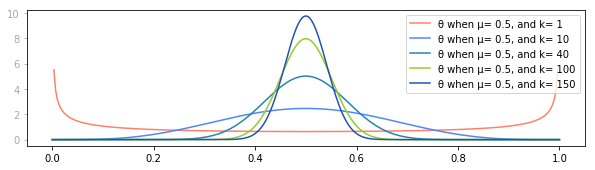

In [39]:
colors = ['#FF8168','#4F86FF','#2284B2','#93CC2B', '#2551B2','#FF4F65','#FFB5AA',]

plt.figure(figsize=(10,2.5))
x = np.linspace(0,1, 300)
mu = [.5,.5,.5,.5,.5]
kappa = [1,10,40,100,150]

for j in range(len(mu)):
    plt.plot(x,stats.beta.pdf(x,mu[j]*kappa[j],(1-mu[j])*kappa[j]), 
             label='θ when μ= '+str(mu[j])+', and k= '+str(kappa[j]), color=colors[j])
plt.legend()
plt.tick_params(axis='y', colors='darkgrey')
plot_images(plt, '4_2')

In [115]:
curr_time = time.time()

with model:
    trace=pm.sample(10000, pm.NUTS())
    
print(np.round(time.time()-curr_time,2), "seconds needed")

100%|██████████████████████████████████████████████████████████████████████████▉| 10494/10500 [00:41<00:00, 252.93it/s]C:\Users\tofed\AppData\Local\conda\conda\envs\pymc3\lib\site-packages\pymc3\step_methods\hmc\nuts.py:467: UserWarning: Chain 0 contains 7 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:41<00:00, 252.92it/s]


43.28 seconds needed


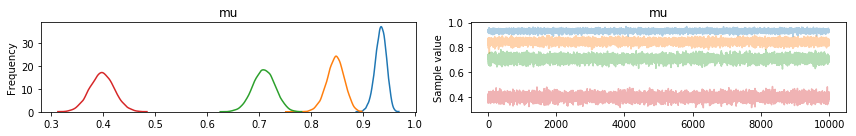

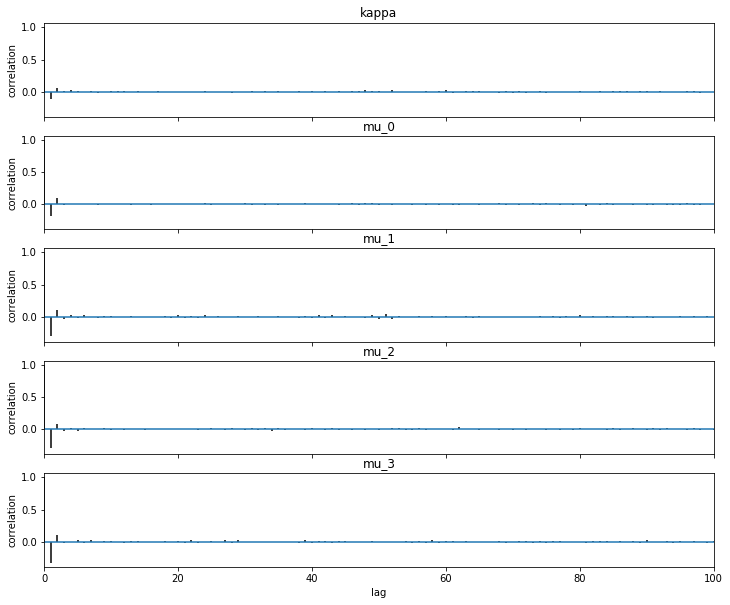

In [55]:
plot_images(pm.traceplot(trace, varnames=['mu']), '4_6')
plot_images(pm.autocorrplot(trace, varnames=['kappa','mu']), '4_7')

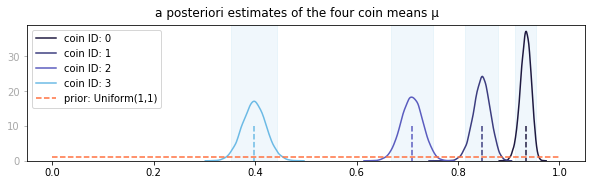

In [40]:
fig = plt.figure(figsize=(10,2.5))
fig.suptitle('a posteriori estimates of the four coin means μ')
ax = fig.gca()
colors = ["#1E1940","#3C3D7F","#5A5CBF", '#6CBAE5']

for j, coin_mu in enumerate(trace['mu'].T):
    sns.distplot(coin_mu, label = 'coin ID: '+str(j), hist=False, ax=ax, color=colors[j])
    ax.fill_between(pm.hpd(coin_mu),[100,100], color='#6CBAE5', alpha=.1)
    ax.vlines(coin_mu.mean(),10,0, linestyles='--', color=colors[j])
    
ax.plot(np.linspace(0,1,100),stats.beta.pdf(np.linspace(0,1,100),1,1), '--', 
        label='prior: Uniform(1,1)', color='#FF703E')
plt.legend()
plt.tick_params(axis='y', colors='darkgrey')
plot_images(plt, '4_3')

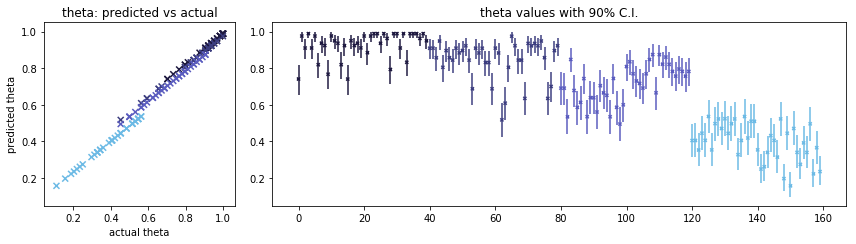

In [42]:
from matplotlib import gridspec

fig = plt.figure(figsize=(12, 3.5)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1,3]) 
ax0 = plt.subplot(gs[0])
ax0.set_title('theta: predicted vs actual')
ax0.scatter(experiments.N_heads/experiments.N_tosses, trace[theta].mean(axis=0), marker='x', alpha=1, color=[colors[i] for i in experiments.coin_ID])

ax0.set_ylabel('predicted theta')
ax0.set_xlabel('actual theta')

ax1 = plt.subplot(gs[1], sharey=ax0)
ax1.set_title('theta values with 90% C.I.')
ax1.scatter(np.arange(trace[theta].shape[1]),np.mean(trace[theta].T,axis=1),
            color=[colors[i] for i in experiments.coin_ID],marker='x',s=10)
ax1.vlines(np.arange(trace[theta].shape[1]),
                         np.percentile(trace[theta].T,q=95,axis=1),
                         np.percentile(trace[theta].T,q=5,axis=1),color=[colors[i] for i in experiments.coin_ID])
plt.tight_layout()
plot_images(plt, '4_4')

## different prior

In [43]:
with pm.Model() as model_2:
    kappa = pm.Gamma('kappa', 1, 0.1)
    mu = pm.Beta('mu', alpha=32, beta=32, shape=number_coins_used) 
    theta = pm.Beta('theta', mu[experiments['coin_ID'].values] * kappa, (1 - mu[experiments['coin_ID'].values]) * kappa, shape=len(experiments))
    y = pm.Binomial('y', p=theta, n=experiments['N_tosses'].values, observed=experiments['N_heads'].values)    
    trace_2=pm.sample(10000, pm.NUTS())

100%|██████████████████████████████████████████████████████████████████████████▉| 10485/10500 [00:43<00:00, 239.05it/s]C:\Users\tofed\AppData\Local\conda\conda\envs\pymc3\lib\site-packages\pymc3\step_methods\hmc\nuts.py:467: UserWarning: Chain 0 contains 1 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:43<00:00, 239.06it/s]


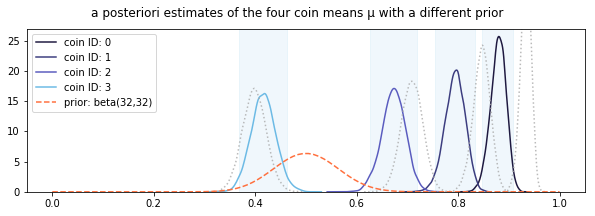

In [44]:
fig = plt.figure(figsize=(10,3))
fig.suptitle('a posteriori estimates of the four coin means μ with a different prior')
ax = fig.gca()
colors = ["#1E1940","#3C3D7F","#5A5CBF", '#6CBAE5']

for j, coin_mu in enumerate(trace_2['mu'].T):
    sns.distplot(coin_mu, label = 'coin ID: '+str(j), hist=False, ax=ax, color=colors[j])
    ax.fill_between(pm.hpd(coin_mu),[100,100], color='#6CBAE5', alpha=.1)
    #ax.vlines(coin_mu.mean(),10,0, linestyles='--', color=colors[j])
for j, coin_mu in enumerate(trace['mu'].T):
    sns.distplot(coin_mu, hist=False, ax=ax, color='darkgrey', kde_kws={'alpha':.8,'linestyle':':'})
ax.plot(np.linspace(0,1,100),stats.beta.pdf(np.linspace(0,1,100),32,32), '--', 
        label='prior: beta(32,32)', color='#FF703E')
plt.legend()
plot_images(plt, '4_extra1')

# checking your chain

In [45]:
with pm.Model() as model:
    kappa = pm.Gamma('kappa', 1, 0.1, )
    mu = pm.Uniform('mu', lower=0, upper=1, shape=number_coins_used) 
    theta = pm.Beta('theta', mu[experiments['coin_ID'].values] * kappa, 
                    (1 - mu[experiments['coin_ID'].values]) * kappa, shape=len(experiments))
    y = pm.Binomial('y', p=theta, n=experiments['N_tosses'].values, observed=experiments['N_heads'].values)    

curr_time = time.time()

with model:
    print('please wait: this could take some time...')
    step1 = pm.Metropolis([mu])
    step2 = pm.Metropolis([theta])
    step3 = pm.Metropolis([kappa])
    trace_bad=pm.sample(5000,[step3, step1, step2], njobs=4, random_seed=123) #njobs for multitrace
    trace_good=pm.sample(5000, pm.NUTS(), njobs=4, random_seed=123)

print(np.round(time.time()-curr_time,2), "seconds needed")

please wait: this could take some time...
88.31 seconds needed


In [46]:
with pm.Model() as model:
    kappa = pm.Gamma('kappa', 1, 0.1, )
    mu = pm.Uniform('mu', lower=0, upper=1, shape=number_coins_used) 
    theta = pm.Beta('theta', mu[experiments['coin_ID'].values] * kappa, 
                    (1 - mu[experiments['coin_ID'].values]) * kappa, shape=len(experiments))
    y = pm.Binomial('y', p=theta, n=experiments['N_tosses'].values, observed=experiments['N_heads'].values)    

curr_time = time.time()


with model:
    print('please wait: this could take some time...')
    step1 = pm.Metropolis([mu])
    step2 = pm.Metropolis([theta])
    step3 = pm.Metropolis([kappa])
    trace_bad_single=pm.sample(5000,[step3, step1, step2], random_seed=123) #njobs for multitrace

print(np.round(time.time()-curr_time,2), "seconds needed")

please wait: this could take some time...


100%|████████████████████████████████████████████████████████████████████████████| 5500/5500 [00:03<00:00, 1664.74it/s]


4.91 seconds needed


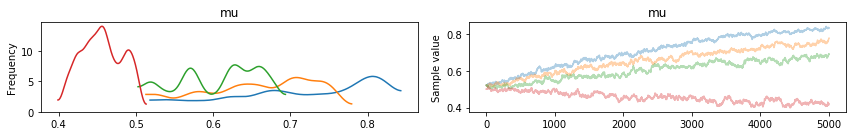

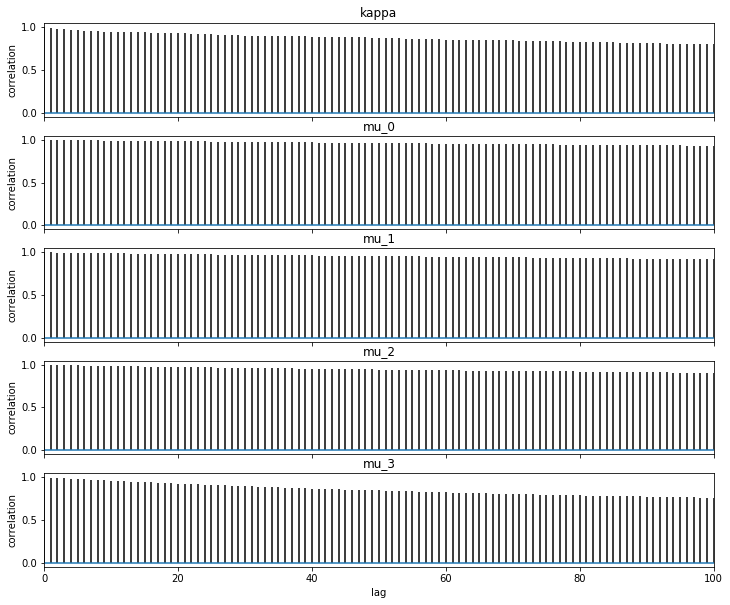

In [80]:
plot_images(pm.traceplot(trace_bad_single, varnames=['mu']), '4_8')
plot_images(pm.autocorrplot(trace_bad_single, varnames=['kappa','mu']), '4_9')


# diagnostical tests

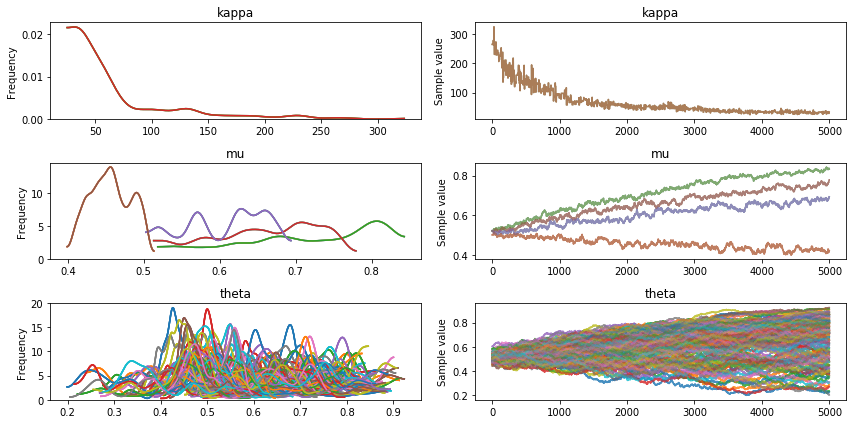

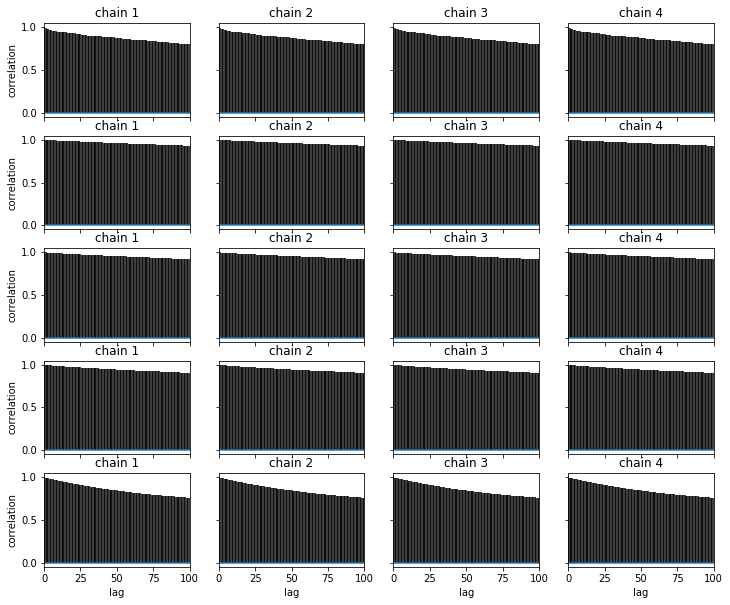

In [85]:
pm.traceplot(trace_bad)
pm.autocorrplot(trace_bad, varnames=['kappa','mu'])
plt.show()

In [88]:
g_r = pm.diagnostics.gelman_rubin(trace_good, varnames=[mu])
pd.DataFrame(np.array(g_r[mu]),columns=['gelman-rubin test for mu']).T

0       1       2       3
gelman-rubin test for mu  0.9999  0.9999  0.9999  0.9999

In [89]:
g_r = pm.diagnostics.gelman_rubin(trace_bad, varnames=[mu])
pd.DataFrame(np.array(g_r[mu]),columns=['gelman-rubin test for mu']).T

0       1       2       3
gelman-rubin test for mu  0.9999  0.9999  0.9999  0.9999

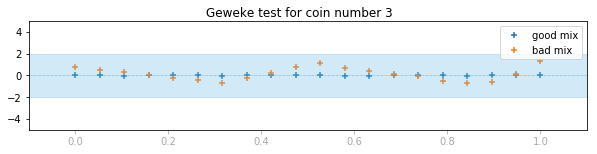

In [92]:
for i in [3]:
    z_scores_bad = np.array(pm.diagnostics.geweke(trace_bad[mu])[i])
    z_scores_good = np.array(pm.diagnostics.geweke(trace_good[mu])[i])
    label = ['good mix', 'bad mix']
    x = np.linspace(0,1,len(z_scores_good.T[0]))
    plt.figure(figsize=(10,2))
    plt.suptitle('Geweke test for coin number '+str(i), size=12)
    
    for j,z_s in enumerate([z_scores_good,z_scores_bad]):
        plt.scatter(x,z_s.T[1], marker='+', label=label[j])
    conf_int = stats.norm(0,1).ppf(.975)
    plt.ylim(-5,5)
    plt.xlim(-.1,1.1)
    plt.fill_between([-1,2],[-conf_int,-conf_int],[conf_int,conf_int], alpha=.3, color='#6CBAE5')
    plt.plot([-2,2],[0,0],':', lw=.5)
    plt.tick_params(axis='x', colors='darkgrey')
    plt.legend(loc=0)
plot_images(plt, '4_13')


In [86]:
av_eff_s = pm.diagnostics.effective_n(trace_good, varnames=[mu])
pd.DataFrame(np.array(av_eff_s[mu])//len(trace_good.chains),columns=['Number of average effective samples for mu']).T

0       1       2       3
Number of average effective samples for mu  5000.0  5000.0  5000.0  5000.0

In [87]:
av_eff_s = pm.diagnostics.effective_n(trace_bad, varnames=[mu])
pd.DataFrame(np.array(av_eff_s[mu])/len(trace_bad.chains),columns=['Number of average effective samples for mu']).T

0     1     2     3
Number of average effective samples for mu  1.75  1.75  1.75  2.25

# section 4.4

(-3, 3)

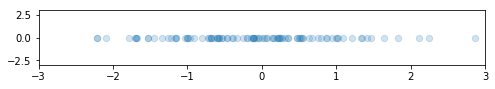

In [93]:
data = stats.norm(0,1).rvs(100, random_state=12)
plt.figure(figsize=(8,1))
plt.scatter(data,stats.norm(0,.00001).rvs(100), marker='o', alpha=.2, s=40)
plt.ylim(-3,3)
plt.xlim(-3,3)

In [77]:
with pm.Model() as model:
    sigma = pm.HalfCauchy('sd',1)
    a = pm.Uniform('a',-20,20)
    b = pm.Uniform('b',-20,20)
    mu = pm.Deterministic('mu',a+b)
    dt = pm.Normal('dt', mu=mu, sd=sigma, observed=data)
    trace_rep1 = pm.sample(2000, random_seed = 124)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
 99%|████████████████████████████████████████████████████████████████████████████▌| 2487/2500 [00:08<00:00, 276.59it/s]C:\Users\tofed\AppData\Local\conda\conda\envs\pymc3\lib\site-packages\pymc3\step_methods\hmc\nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.501260406055, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
C:\Users\tofed\AppData\Local\conda\conda\envs\pymc3\lib\site-packages\pymc3\step_methods\hmc\nuts.py:467: UserWarning: Chain 0 contains 285 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|█████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:09<00:00, 276.69it/s]


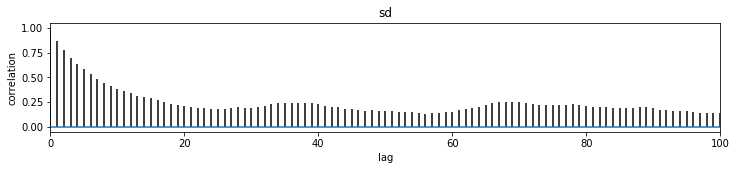

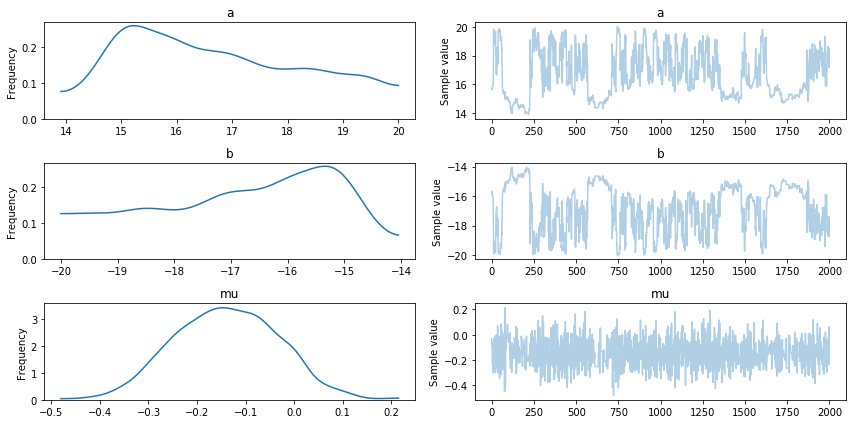

In [94]:
plot_images(pm.autocorrplot(trace_rep1, varnames=['sd']), '4_12')
plot_images(pm.traceplot(trace_rep1, varnames=[a,b,mu]), '4_14')

In [62]:
with pm.Model() as model_2:
    sigma = pm.HalfCauchy('sd',1)
    a = pm.Normal('a',0,10)
    b = pm.Normal('b',0,10)
    mu = pm.Deterministic('mu',a+b)
    dt = pm.Normal('dt', mu=mu, sd=sigma, observed=data)
    trace_2 = pm.sample(2000, pm.NUTS(),random_seed = 125)

100%|█████████████████████████████████████████████████████████████████████████████▊| 2494/2500 [00:40<00:00, 61.66it/s]C:\Users\tofed\AppData\Local\conda\conda\envs\pymc3\lib\site-packages\pymc3\step_methods\hmc\nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.892385167822, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:40<00:00, 61.55it/s]


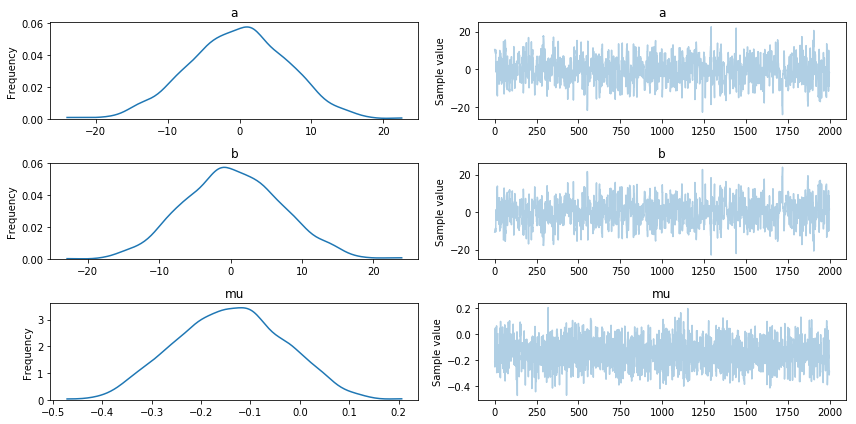

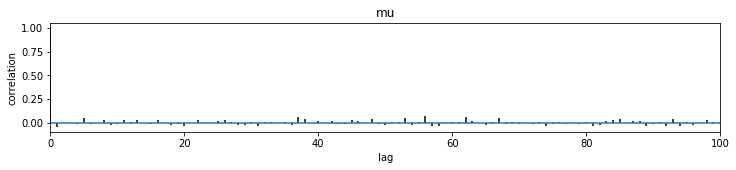

In [95]:
plot_images(pm.traceplot(trace_2, varnames=[a,b,mu]),'4_15')
plot_images(pm.autocorrplot(trace_2, varnames=['mu']), '4_11')


In [96]:
with pm.Model() as model_3:
    sigma = pm.HalfCauchy('sd',1)
    c = pm.Normal('c',0,10)
    y = pm.Normal('y', mu=c, sd=sigma, observed=data)
    trace_3_rep = pm.sample(4000, pm.NUTS())

100%|████████████████████████████████████████████████████████████████████████████| 4500/4500 [00:02<00:00, 2228.88it/s]


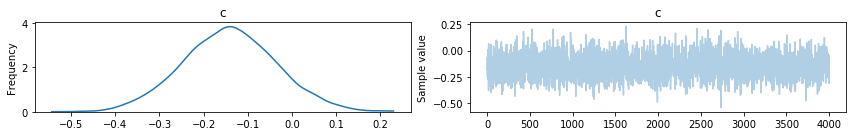

In [99]:
plot_images(pm.traceplot(trace_3_rep, varnames=[c]),'4_16')

In [102]:
pm.math.invlogit(3).eval()

array(0.952574148457255)

# section 4.4

In [106]:
from theano import tensor as tt

with pm.Model() as model_f_s:
    sigma = pm.HalfCauchy('sigma', 1, shape=number_coins_used)
    mu = pm.Normal('mu', mu=0, sd=10, shape=number_coins_used) 
    theta = pm.Normal("theta", 
                              mu=mu[experiments['coin_ID'].values],
                              sd=sigma[experiments['coin_ID'].values], 
                              shape=len(experiments))
    p = pm.Deterministic('p', pm.math.invlogit(theta))
    y = pm.Binomial('y', p=p, n=experiments['N_tosses'].values, observed=experiments['N_heads'].values)    

curr_time = time.time()

with model_f_s:
    step1 = pm.Metropolis([mu])
    step2 = pm.Metropolis([sigma])
    step3 = pm.NUTS([theta])
    step4 = pm.Metropolis([p])
    trace_bad_f_s=pm.sample(10000,[step1,step2,step3], random_seed=123) #njobs for multitrace

print(np.round(time.time()-curr_time,2), "seconds needed")

100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:35<00:00, 298.03it/s]


37.15 seconds needed


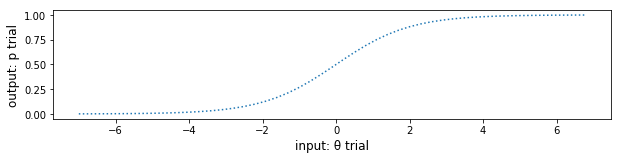

In [107]:
plt.figure(figsize=(10,2))
plt.plot(np.arange(-7,7,.3),pm.math.invlogit(np.arange(-7,7,.3)).eval(),':')
plt.gca().set_xlabel('input: θ trial', size=12)
plt.gca().set_ylabel('output: p trial', size=12)
plot_images(plt, '4_17')

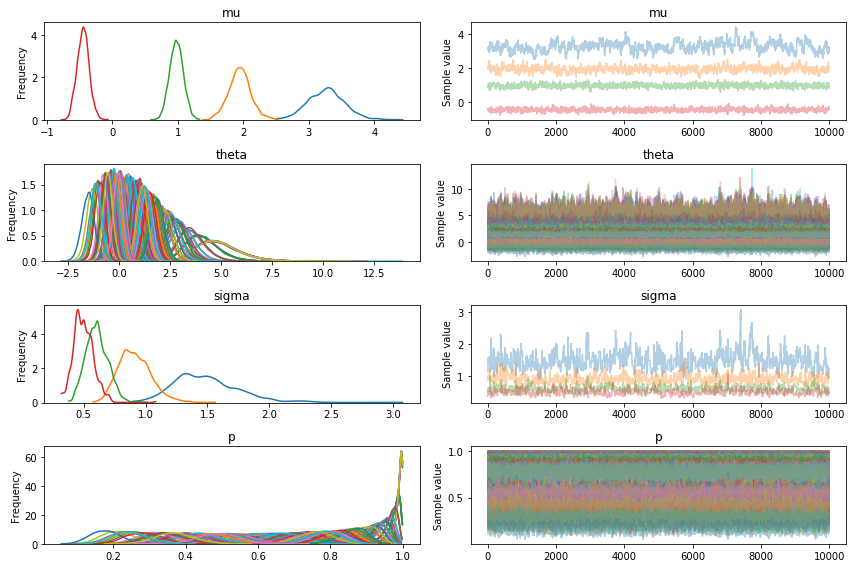

In [108]:
pm.traceplot(trace_bad_f_s)
plt.show()

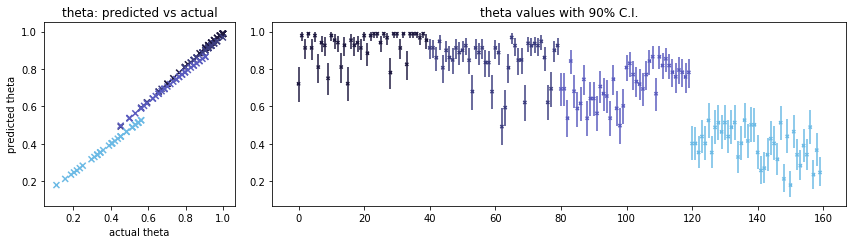

In [116]:
from matplotlib import gridspec

fig = plt.figure(figsize=(12, 3.5)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1,3]) 
ax0 = plt.subplot(gs[0])
ax0.set_title('theta: predicted vs actual')
ax0.scatter(experiments.N_heads/experiments.N_tosses, trace_bad_f_s[p].mean(axis=0), marker='x', alpha=1, color=[colors[i] for i in experiments.coin_ID])

ax0.set_ylabel('predicted theta')
ax0.set_xlabel('actual theta')

ax1 = plt.subplot(gs[1], sharey=ax0)
ax1.set_title('theta values with 90% C.I.')
ax1.scatter(np.arange(trace_bad_f_s[p].shape[1]),np.mean(trace_bad_f_s[p].T,axis=1),
            color=[colors[i] for i in experiments.coin_ID],marker='x',s=10)
ax1.vlines(np.arange(trace_bad_f_s[theta].shape[1]),
                         np.percentile(trace_bad_f_s[p].T,q=95,axis=1),
                         np.percentile(trace_bad_f_s[p].T,q=5,axis=1),color=[colors[i] for i in experiments.coin_ID])
plt.tight_layout()
plot_images(plt, '4_18')

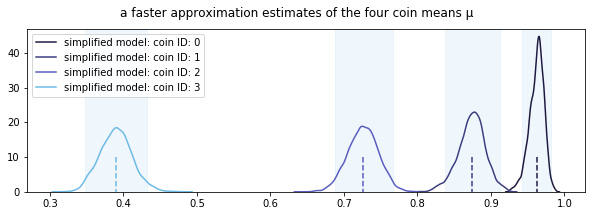

In [112]:
fig = plt.figure(figsize=(10,3))
fig.suptitle('a faster approximation estimates of the four coin means μ')
ax = fig.gca()
colors = ["#1E1940","#3C3D7F","#5A5CBF", '#6CBAE5']
    
for j, coin_mu in enumerate(trace_bad_f_s['mu'].T):
    coin_mu = pm.math.invlogit(coin_mu).eval()
    sns.distplot(coin_mu, label = 'simplified model: coin ID: '+str(j), hist=False, ax=ax, color=colors[j])
    ax.fill_between(pm.hpd(coin_mu),[100,100], color='#6CBAE5', alpha=.1)
    ax.vlines(coin_mu.mean(),10,0, linestyles='--', color=colors[j])
    

plt.legend()
plt.show()

In [117]:
with pm.Model() as model_f_s:
    sigma = pm.HalfCauchy('sigma', 1, shape=number_coins_used)
    mu = pm.Beta('mu', alpha=1, beta=1, shape=number_coins_used) 
    theta = pm.Normal("theta", 
                              mu=mu[experiments['coin_ID'].values],
                              sd=sigma[experiments['coin_ID'].values], 
                              shape=len(experiments))
    y = pm.Binomial('y', p=tt.clip(theta,0,1), n=experiments['N_tosses'].values, observed=experiments['N_heads'].values)    

curr_time = time.time()

with model_f_s:
    step1 = pm.Metropolis([mu])
    step2 = pm.Metropolis([sigma])
    step3 = pm.NUTS([theta])
    trace_bad_f_s=pm.sample(10000,[step1,step2,step3], random_seed=123) #njobs for multitrace

print(np.round(time.time()-curr_time,2), "seconds needed")

 99%|██████████████████████████████████████████████████████████████████████████▍| 10418/10500 [00:17<00:00, 591.09it/s]C:\Users\tofed\AppData\Local\conda\conda\envs\pymc3\lib\site-packages\pymc3\step_methods\hmc\nuts.py:437: UserWarning: Chain 0 contains only diverging samples. The model is probably misspecified.
  % self._chain_id)
C:\Users\tofed\AppData\Local\conda\conda\envs\pymc3\lib\site-packages\pymc3\step_methods\hmc\nuts.py:467: UserWarning: Chain 0 contains 10000 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|███████████████████████████████████████████████████████████████████████████| 10500/10500 [00:17<00:00, 592.90it/s]


19.52 seconds needed


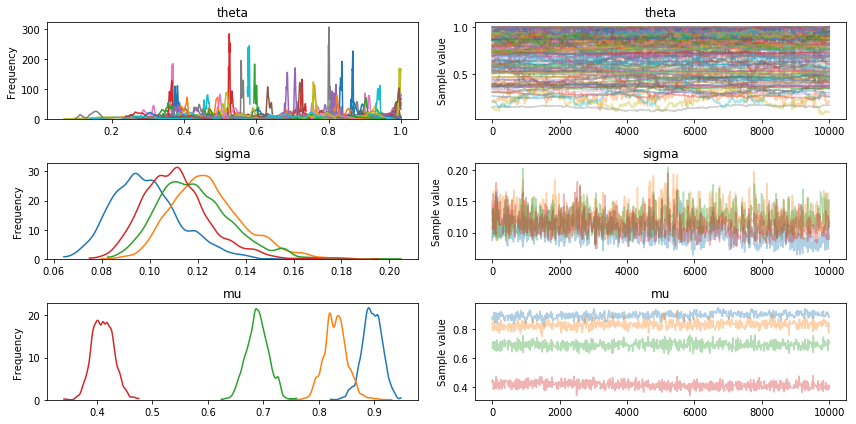

In [118]:
pm.traceplot(trace_bad_f_s)
plt.show()

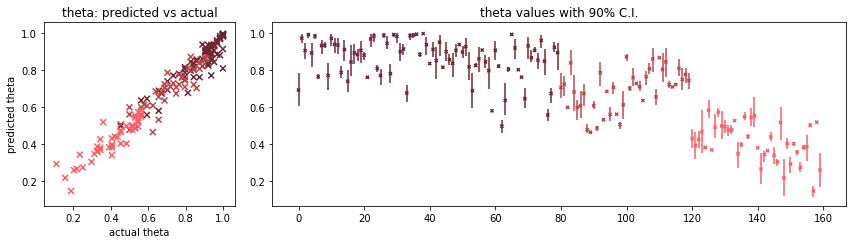

In [121]:
from matplotlib import gridspec

colors = ["#6E2343","#6E282B","#BF454A","#FF5D63"]

fig = plt.figure(figsize=(12, 3.5)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1,3]) 
ax0 = plt.subplot(gs[0])
ax0.set_title('theta: predicted vs actual')
ax0.scatter(experiments.N_heads/experiments.N_tosses, trace_bad_f_s[theta].mean(axis=0), marker='x', alpha=1, color=[colors[i] for i in experiments.coin_ID])

ax0.set_ylabel('predicted theta')
ax0.set_xlabel('actual theta')

ax1 = plt.subplot(gs[1], sharey=ax0)
ax1.set_title('theta values with 90% C.I.')
ax1.scatter(np.arange(trace_bad_f_s[theta].shape[1]),np.mean(trace_bad_f_s[theta].T,axis=1),
            color=[colors[i] for i in experiments.coin_ID],marker='x',s=10)
ax1.vlines(np.arange(trace_bad_f_s[theta].shape[1]),
                         np.percentile(trace_bad_f_s[theta].T,q=95,axis=1),
                         np.percentile(trace_bad_f_s[theta].T,q=5,axis=1),color=[colors[i] for i in experiments.coin_ID])
plt.tight_layout()
plot_images(plt, '4_19')

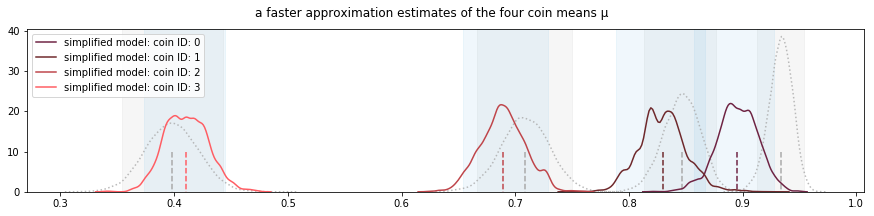

In [122]:
fig = plt.figure(figsize=(15,3))
fig.suptitle('a faster approximation estimates of the four coin means μ')
ax = fig.gca()

for j, coin_mu in enumerate(trace['mu'].T):
    sns.distplot(coin_mu, hist=False, ax=ax, color='darkgrey', kde_kws={'alpha':.8,'linestyle':':'})
    ax.fill_between(pm.hpd(coin_mu),[100,100], color='darkgrey', alpha=.1)
    ax.vlines(coin_mu.mean(),10,0, linestyles='--', color='darkgrey')
    
for j, coin_mu in enumerate(trace_bad_f_s['mu'].T):
    sns.distplot(coin_mu, label = 'simplified model: coin ID: '+str(j), hist=False, ax=ax, color=colors[j])
    ax.fill_between(pm.hpd(coin_mu),[100,100], color='#6CBAE5', alpha=.1)
    ax.vlines(coin_mu.mean(),10,0, linestyles='--', color=colors[j])
    

plt.legend()
plot_images(plt, '4_20')